# Module 8 — Multi-Agent Collaboration & Workflow Design (Hands-On)

**Topic:** End-to-End Transaction Monitoring with Specialized Agents (Ingestion → Risk Assessment → Enrichment → Escalation → Reporting)  
**Stack:** Python • LangChain • LangGraph • Azure OpenAI • VS Code Notebooks  
**Duration:** ~2 hours  



## Learning Outcomes
- Explain MAS concepts: specialization, delegation, protocols, memory/state, supervision.
- Build an end-to-end multi-agent pipeline for AML/compliance-style monitoring.
- Orchestrate with LangGraph, including retries and validation.
- Produce a concise, investigation-ready report for escalations.


## 0) Environment Setup
Run to install dependencies (skip if already installed).


In [1]:
%pip install --upgrade pip

  Using cached pip-25.2-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.1
    Uninstalling pip-25.1:
      Successfully uninstalled pip-25.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install langchain langgraph langchain-openai openai tiktoken pandas numpy pydantic python-dotenv rich

Note: you may need to restart the kernel to use updated packages.



### Configure OpenAI
Create `.env` with:
```
OPENAI_API_KEY=YOUR_KEY
```


In [3]:
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger("MAS-Pipeline")

## 1) Imports, Paths, and Environment Loading

In [4]:
from dotenv import load_dotenv
import os, json, re
import pandas as pd
import numpy as np
from pydantic import BaseModel, Field, confloat
from typing import List, Optional, Literal, Dict, Any
from rich import print as rprint

from langchain.schema.runnable import RunnableLambda, RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# --- CHANGE 1: Import ChatOpenAI instead of AzureChatOpenAI ---
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

load_dotenv()
# --- CHANGE 2: Use standard OpenAI environment variables ---
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")
# Define the model to use (e.g., "gpt-4o", "gpt-3.5-turbo")
MODEL_NAME = "gpt-4o"

assert OPENAI_API_KEY, "Set OPENAI_API_KEY env var in .env"

# --- CHANGE 3: Initialize ChatOpenAI using the API Key and model_name ---
llm = ChatOpenAI(
    api_key=OPENAI_API_KEY,
    model_name=MODEL_NAME,
    temperature=0.2,
    max_tokens=700
)
rprint(f"[bold green]OpenAI (LangChain) ready with model: {MODEL_NAME}[/bold green]")

d:\Courses\DataScience\AI\AgenticAI\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OpenAI (LangChain) ready with model: gpt-4o


## 2) Data Familiarization
### Data Loading & Preparation (Step Explanation)

This block of code performs the following tasks:

1. **Define file paths**  
   - Specifies the locations of three datasets:  
      * [financial_transactions.csv](https://drive.google.com/file/d/1Og3xMLYEBvLAY2aQmKQXbkgyaq2-dHT1/view?usp=sharing) → contains raw financial transaction records.
      * [financial_risk_assessment.csv](https://drive.google.com/file/d/15ojKPlJwBrLDUPsMm1GDYf5gedINBsyu/view?usp=sharing)→ contains risk assessment data (e.g., customer risk indicators).
      * [04-01-Financial Sample Data.xlsx](https://docs.google.com/spreadsheets/d/1bMNubf8xfRaoIgLxlmp9l8ym4QepDj8f/edit?usp=sharing&ouid=109274696981125836014&rtpof=true&sd=true)→ optional Excel file with auxiliary financial data.

2. **Load data into Pandas**  
   - Reads the transactions and risk CSVs into DataFrames.  
   - Attempts to open the Excel file; if successful, loads the first sheet, otherwise sets it to an empty DataFrame and prints a message.

3. **Data cleaning and normalization**  
   - Converts the `date` column to proper datetime format.  
   - Standardizes the `type` column by making all text lowercase and removing extra spaces.  
   - Cleans the `description` column by stripping whitespace.

4. **Create a working batch**  
   - Sorts transactions by date (oldest first).  
   - Selects the first 200 rows to form a **mini batch** for faster processing during experiments.

5. **Quick verification**  
   - Prints the shape (rows × columns) of all three datasets.  
   - Displays the first 5 rows of the prepared batch for inspection.

**Why this matters:**  
This step ensures that the raw data is properly loaded, cleaned, and reduced to a manageable subset before passing it into the multi-agent transaction monitoring pipeline.


In [6]:

TRANSACTIONS_PATH = "D:\\Courses\\DataScience\\AI\\AgenticAI\\resources\\data\\financial_transactions.csv"
RISK_PATH = "D:\\Courses\\DataScience\\AI\\AgenticAI\\resources\\data\\financial_risk_assessment.csv"
XLSX_PATH = "D:\\Courses\\DataScience\\AI\\AgenticAI\\resources\\data\\04-01-Financial Sample Data.xlsx"

tx = pd.read_csv(TRANSACTIONS_PATH)
risk = pd.read_csv(RISK_PATH)
try:
    xls = pd.ExcelFile(XLSX_PATH); aux = pd.read_excel(xls, xls.sheet_names[0])
except Exception as e:
    aux = pd.DataFrame(); print("Optional XLSX not loaded:", e)

tx['date'] = pd.to_datetime(tx['date'], errors='coerce')
tx['type'] = tx['type'].astype(str).str.strip().str.lower()
tx['description'] = tx['description'].astype(str).str.strip()

BATCH_SIZE = 200
tx_batch = tx.sort_values('date', ascending=True).head(BATCH_SIZE).copy()

rprint({"transactions_shape": tx.shape, "risk_shape": risk.shape, "aux_shape": aux.shape if not aux.empty else "empty"})
tx_batch.head(5)


{'transactions_shape': (100000, 6), 'risk_shape': (15000, 20), 'aux_shape': (711, 16)}

,transaction_id,date,customer_id,amount,type,description
41889,41890,2018-03-27,875,3732.14,debit,Standard save certain enough message.
80704,80705,2018-03-27,987,8078.20,transfer,On go stage.
4212,4213,2018-03-27,867,8415.26,debit,Position shoulder prevent loss.
23938,23939,2018-03-27,874,8321.54,transfer,You late language first range like between.
63703,63704,2018-03-27,436,7158.44,debit,Just billion peace court wish.


### Feature Engineering (Step Explanation)

This block of code creates additional features to help the risk assessment agent make better decisions:

1. **Transaction amount z-score (`amount_z`)**  
   - Calculates the global mean and standard deviation of all transaction amounts.  
   - Standardizes each transaction’s amount into a z-score (how many standard deviations away from the mean it is).  
   - Helps identify unusually large or small transactions.

2. **Customer transaction velocity (`c_txn_7d`)**  
   - Sorts transactions per customer by date.  
   - For each transaction, counts how many **previous transactions** the same customer made in the **last 7 days**.  
   - Captures velocity or bursty transaction patterns, which may signal risk.

3. **Keyword flag (`kw_flag`)**  
   - Searches the transaction description for risky keywords such as *crypto, cash, gift, urgent, refund, invoice split, transfer split, exchange*.  
   - Flags transactions containing these terms with `1`, otherwise `0`.  
   - Helps highlight suspicious narratives in free-text fields.

4. **Merge with risk dataset**  
   - If the risk dataset contains a `customer_id` column, merges risk indicators into the transaction batch.  
   - Ensures each transaction also carries customer-level risk context (e.g., PEP flag, prior alerts, jurisdiction risk).

5. **Preview**  
   - Displays the first 10 rows of the enhanced dataset, now containing engineered features alongside the raw data.

**Why this matters:**  
These engineered features (amount z-scores, velocity counts, risky keywords, and merged risk attributes) provide richer signals for the multi-agent pipeline, allowing the Risk Assessment and Escalation agents to detect high-risk activity more effectively.



In [7]:
amt_mean = tx['amount'].mean(); amt_std = tx['amount'].std(ddof=0) or 1.0
tx_batch['amount_z'] = (tx_batch['amount'] - amt_mean) / amt_std

tx_batch = tx_batch.sort_values(['customer_id','date'])
tx_batch['c_txn_7d'] = 0
for cid, grp in tx_batch.groupby('customer_id'):
    idxs = grp.index.tolist()
    for i, idx in enumerate(idxs):
        d = grp.loc[idx, 'date']
        c = grp[(grp['date'] >= d - pd.Timedelta(days=7)) & (grp['date'] < d)].shape[0]
        tx_batch.loc[idx, 'c_txn_7d'] = c

import re
kw = re.compile(r"\b(crypto|cash|gift|urgent|refund|invoice split|transfer split|exchange)\b", re.I)
tx_batch['kw_flag'] = tx_batch['description'].fillna("").str.contains(kw).astype(int)

if 'customer_id' in risk.columns:
    tx_batch = tx_batch.merge(risk, on='customer_id', how='left', suffixes=('','_risk'))

tx_batch.head(10)


C:\Users\IndrajitS\AppData\Local\Temp\ipykernel_20592\1392742177.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  tx_batch['kw_flag'] = tx_batch['description'].fillna("").str.contains(kw).astype(int)


,transaction_id,date,customer_id,amount,type,description,amount_z,c_txn_7d,kw_flag
85776,85777,2018-03-28,1,5570.42,transfer,Kid win despite wonder tonight support.,0.194364,0,0
26853,26854,2018-03-27,2,2308.05,credit,Short good evening claim.,-0.935097,0,0
5026,5027,2018-03-28,6,9568.49,debit,Street note day card.,1.578532,0,0
8023,8024,2018-03-29,8,1992.87,credit,Actually in Republican can police.,-1.044216,0,0
66193,66194,2018-03-27,15,8557.44,transfer,Article around only discuss draw remain.,1.228497,0,0
61638,61639,2018-03-27,19,7388.97,debit,Reflect trade management daughter age occur fe...,0.823962,0,0
71579,71580,2018-03-28,19,4276.99,debit,Government debate mean left other central.,-0.253433,1,0
92286,92287,2018-03-28,31,1174.76,debit,Us war break draw Mr which.,-1.327453,0,0
41241,41242,2018-03-29,35,2410.00,debit,Say walk book option line attack think.,-0.899801,0,0
7079,7080,2018-03-29,39,7040.23,debit,Try activity role exactly save story open.,0.703226,0,0


## 3) Data Models and Schemas

In this step, we define **Pydantic models** to standardize the inputs and outputs exchanged between agents in our multi-agent pipeline. These models enforce structure, ensure data validation, and make communication between agents more reliable.

1. **`TxnEvent`**  
   - Represents a single financial transaction after ingestion and feature engineering.  
   - Fields include transaction details (`transaction_id`, `date`, `customer_id`, `amount`, `type`, `description`) and engineered features (`amount_z`, `c_txn_7d`, `kw_flag`).

2. **`RiskLabel`**  
   - Output of the **Risk Assessment Agent**.  
   - Contains:  
     - `risk_level` → categorical label: *Low*, *Medium*, or *High*.  
     - `score` → numeric confidence between 0 and 1.  
     - `reason` → short explanation of why the risk level was chosen.

3. **`Enrichment`**  
   - Output of the **Counterparty Enrichment Agent**.  
   - Adds customer-level risk context:  
     - `pep_flag` (Politically Exposed Person indicator).  
     - `country_risk` (jurisdiction risk: Low, Medium, High).  
     - `prior_alerts_90d` (recent alerts count).  
     - `extra` (catch-all for additional attributes from the risk dataset).

4. **`EscalationDecision`**  
   - Output of the **Escalation Agent**.  
   - Determines if a case should be escalated.  
   - Fields:  
     - `create_case` → Boolean flag.  
     - `severity` → escalation level (*Info, Low, Medium, High, Critical*).  
     - `playbook_path` → which escalation playbook to follow.  
     - `reason` → explanation of the decision.

5. **`ReportDoc`**  
   - Output of the **Report Agent** for escalated cases.  
   - Structured draft of a compliance report with:  
     - `title`, `summary`, `indicators`, `counterparty_context`, `timeline`, and `recommendation`.

6. **`CaseState`**  
   - Master container passed through the workflow.  
   - Holds the evolving state of a case across agents: the original transaction (`txn`), risk label, enrichment data, escalation decision, generated report, and execution `logs`.

**Why this matters:**  
These schemas act as the **contract** between agents, ensuring each one knows exactly what data to expect and produce. This makes the pipeline modular, auditable, and easier to debug or extend.



In [8]:
class TxnEvent(BaseModel):
    transaction_id: int
    date: str
    customer_id: int
    amount: float
    type: str
    description: str
    amount_z: float
    c_txn_7d: int
    kw_flag: int

class RiskLabel(BaseModel):
    risk_level: Literal["Low","Medium","High"]
    score: confloat(ge=0, le=1) = 0.0
    reason: str

class Enrichment(BaseModel):
    customer_id: int
    pep_flag: Optional[bool] = None
    country_risk: Optional[Literal["Low","Medium","High"]] = None
    prior_alerts_90d: Optional[int] = None
    extra: Dict[str, Any] = {}

class EscalationDecision(BaseModel):
    create_case: bool
    severity: Optional[Literal["Info","Low","Medium","High","Critical"]] = None
    playbook_path: Optional[str] = None
    reason: str

class ReportDoc(BaseModel):
    title: str = Field(..., description="Concise case title")
    summary: str = Field(..., description="Short neutral summary")
    indicators: List[str] = Field(..., description="Key red flags or indicators")
    counterparty_context: str = Field(..., description="Details on counterparties, customers, or entities")
    timeline: List[str] = Field(..., description="Chronological sequence of important events")
    recommendation: str = Field(..., description="Suggested next steps or recommendation")

    class Config:
        extra = "forbid"

class CaseState(BaseModel):
    txn: Optional[TxnEvent] = None
    risk: Optional[RiskLabel] = None
    enrichment: Optional[Enrichment] = None
    decision: Optional[EscalationDecision] = None
    report: Optional[ReportDoc] = None
    logs: List[str] = []


## 4) Rule-Based Scoring Function

This function (`score_rules`) implements a **deterministic risk scoring system** that complements the LLM-based risk assessment. It assigns points based on specific red flags and produces a base risk level.

1. **Country Risk Map (`COUNTRY_RISK_MAP`)**  
   - Defines sets of countries with *High*, *Medium*, or *Low* risk.  
   - Can be used to enrich transactions with jurisdiction-based risk scores.

2. **Scoring Logic**  
   The function examines a transaction (row) and optionally enrichment data, then assigns points based on risk factors:

   - **Transaction Amount**  
     - ≥ 10,000 → +3 points (“High amount”).  
     - 3,000–9,999 → +1 point (“Elevated amount”).

   - **Transaction Velocity**  
     - ≥ 10 transactions in the past 7 days → +2 points.

   - **Keyword Flag**  
     - If the description contains suspicious keywords → +1 point.

   - **Enrichment Factors** *(if available)*  
     - High-risk country → +2 points.  
     - Medium-risk country → +1 point.  
     - PEP (Politically Exposed Person) flag → +3 points.  
     - ≥ 2 prior alerts in the past 90 days → +1 point.

3. **Base Risk Level**  
   - If **points ≥ 5** → `High`  
   - If **2 ≤ points < 5** → `Medium`  
   - Otherwise → `Low`

4. **Return Value**  
   The function returns a dictionary with:  
   - `points` → total score  
   - `base_level` → Low, Medium, or High  
   - `reasons` → list of triggered rules (text explanations)

**Why this matters:**  
This rule-based engine provides **transparent, auditable logic** that explains why a transaction is considered risky. Combined with LLM reasoning, it forms a **hybrid system** where machine learning augments but does not replace clear compliance rules.



In [9]:
def score_rules(row: pd.Series, enrichment: Dict[str, Any] | None = None) -> Dict[str, Any]:
    points, reasons = 0, []
    amt = float(row.get("amount", 0))

    # Amount-based scoring
    if amt >= 5000:
        points += 3; reasons.append("High amount >= 5000")
    elif amt >= 2500:  # lowered threshold for demo
        points += 1; reasons.append("Elevated amount 2,500–9,999")

    # Transaction velocity
    if int(row.get("c_txn_7d", 0)) >= 5:  # lowered from 10
        points += 2; reasons.append("High velocity (>=5 txns in 7d)")

    # Keyword triggers
    if int(row.get("kw_flag", 0)) == 1:
        points += 1; reasons.append("Risk keyword in description")

    # Enrichment factors
    if enrichment:
        cr = enrichment.get("country_risk")
        if cr == "High":
            points += 2; reasons.append("High country risk")
        elif cr == "Medium":
            points += 1; reasons.append("Medium country risk")
        if enrichment.get("pep_flag") is True:
            points += 3; reasons.append("PEP flagged")
        pa = enrichment.get("prior_alerts_90d")
        if isinstance(pa, (int, float)) and pa >= 2:
            points += 1; reasons.append("Multiple prior alerts in 90d")

    # Risk level assignment
    base = "High" if points >= 5 else ("Medium" if points >= 1 else "Low")
    return {"points": points, "base_level": base, "reasons": reasons}

### 5.1 Ingestion Helper — `make_txn_event`

This function converts a single Pandas DataFrame row into a structured `TxnEvent` object.  
It ensures that every transaction is represented in a **standardized schema** before passing through the multi-agent pipeline.

**Key steps:**

1. **Extract core transaction details**  
   - `transaction_id` → unique identifier.  
   - `date` → converted to ISO 8601 string (standard timestamp format).  
   - `customer_id` → numeric customer reference.  
   - `amount` → transaction value as a float.  
   - `type` → standardized transaction type (string).  
   - `description` → free-text narrative of the transaction.

2. **Attach engineered features**  
   - `amount_z` → standardized z-score of transaction amount.  
   - `c_txn_7d` → count of previous transactions for this customer in the past 7 days.  
   - `kw_flag` → binary flag if risky keywords were found in the description.

3. **Validation and defaults**  
   - Uses type casting (`int`, `float`, `str`) to enforce correct data types.  
   - Provides safe defaults (`0` or empty string) if values are missing.

**Why this matters:**  
By transforming raw DataFrame rows into validated `TxnEvent` objects, the ingestion step guarantees a **consistent input format** for all downstream agents, improving reliability and reducing schema errors.


In [10]:

def make_txn_event(row: pd.Series) -> TxnEvent:
    return TxnEvent(
        transaction_id = int(row["transaction_id"]),
        date = pd.to_datetime(row["date"]).isoformat() if pd.notna(row["date"]) else "",
        customer_id = int(row["customer_id"]),
        amount = float(row["amount"]),
        type = str(row["type"]),
        description = str(row.get("description","")),
        amount_z = float(row.get("amount_z",0.0)),
        c_txn_7d = int(row.get("c_txn_7d",0)),
        kw_flag = int(row.get("kw_flag",0)),
    )


### 5.2 Risk Assessment Agent

This agent is responsible for classifying each transaction’s risk level.  
It combines **rule-based signals** with **LLM reasoning** to produce a structured risk label.

**How it works:**

1. **Prompt Design**  
   - A `ChatPromptTemplate` defines the role of the LLM:  
     - **System message**: tells the model to act as a *compliance risk analyst*.  
     - **Human message**: provides two key inputs:  
       - `txn_json` → the transaction data (from `TxnEvent`).  
       - `rule_summary` → hints from the deterministic scoring engine (`score_rules`).  
     - The model is instructed to output JSON only, with three fields:
       - `risk_level` → Low, Medium, or High.  
       - `score` → confidence value between 0 and 1 (e.g., High ≈ 0.85, Medium ≈ 0.5, Low ≈ 0.2).  
       - `reason` → a concise justification (1–3 sentences).

2. **Function `risk_agent`**  
   - Combines the `risk_prompt` with the LLM, forcing output into the `RiskLabel` schema via `with_structured_output`.  
   - Passes transaction details (`txn_json`) and the rulebook summary to the model.  
   - Returns a validated `RiskLabel` object.

3. **Outputs**  
   - A standardized risk classification with:  
     - Categorical level (*Low/Medium/High*).  
     - Numeric confidence score.  
     - A short rationale explaining the decision.

**Why this matters:**  
This agent demonstrates how **hybrid reasoning** works in compliance:  
- **Rules** provide consistency and auditability.  
- **LLMs** add contextual interpretation and narrative explanations.  
Together, they create a more trustworthy and transparent risk assessment process.


In [12]:

risk_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a compliance risk analyst. Classify a single transaction as Low, Medium, or High risk. "
               "Use provided features and rulebook hints. Respond in JSON only."),
    ("human", "Transaction:\n{txn_json}\n\nRulebook summary:\n{rule_summary}\n\n"
              "Instructions:\n"
              "- Decide risk_level in [Low, Medium, High].\n"
              "- Set score in [0,1] indicating confidence (e.g., High=0.85, Medium=0.5, Low=0.2).\n"
              "- Provide a concise reason (1-3 sentences).")
])

def risk_agent(txn: TxnEvent, rule_hints: Dict[str, Any]) -> RiskLabel:
    chain = risk_prompt | llm.with_structured_output(RiskLabel)
    return chain.invoke({
        "txn_json": json.dumps(txn.model_dump(), ensure_ascii=False),
        "rule_summary": json.dumps(rule_hints, ensure_ascii=False)
    })


### 5.3 Counterparty Enrichment Agent

This agent enriches a transaction with **customer-level risk attributes** by cross-referencing the risk dataset.  
It provides additional context beyond the raw transaction features.

**How it works:**

1. **Customer Lookup**  
   - Checks whether the `risk` dataset contains a matching record for the given `customer_id`.  
   - If found, retrieves the first matching row.

2. **Extract Key Risk Features**  
   From the customer record, it attempts to identify and normalize:  
   - **PEP flag (`pep_flag`)** → Boolean value indicating if the customer is a Politically Exposed Person.  
   - **Country Risk (`country_risk`)** → Categorical risk label: *Low, Medium, High*.  
   - **Prior Alerts (`prior_alerts_90d`)** → Number of alerts linked to this customer in the last 90 days.

3. **Collect Extra Attributes**  
   - Copies all available columns from the risk dataset row into an `extra` dictionary.  
   - Preserves flexibility by capturing additional risk signals not explicitly modeled.

4. **Output**  
   - Returns an `Enrichment` object containing the enriched attributes for the customer.  
   - If no record is found, the enrichment fields remain `None` (empty).

**Why this matters:**  
The enrichment agent provides **contextual intelligence** about the customer:  
- Is this individual a PEP?  
- Are they operating in a high-risk jurisdiction?  
- Do they have a history of prior alerts?  

This enriched context significantly improves the accuracy of escalation decisions and final reporting.


In [13]:

def enrichment_agent(txn: TxnEvent) -> Enrichment:
    row = None
    if "customer_id" in risk.columns:
        sub = risk[risk["customer_id"] == txn.customer_id]
        row = sub.iloc[0] if not sub.empty else None

    pep_flag = None; cr = None; prior_alerts = None; extra = {}
    if row is not None:
        for col in risk.columns: extra[col] = row[col]
        for candidate in ["pep","pep_flag","is_pep"]:
            if candidate in risk.columns:
                val = row[candidate]
                pep_flag = bool(val) if pd.notna(val) else None
                break
        for candidate in ["country_risk","risk_country","jurisdiction_risk"]:
            if candidate in risk.columns:
                val = str(row[candidate]).strip().title()
                cr = val if val in {"Low","Medium","High"} else None
                break
        for candidate in ["prior_alerts_90d","alerts_90d","prior_alerts"]:
            if candidate in risk.columns:
                v = row[candidate]
                prior_alerts = int(v) if pd.notna(v) else None
                break

    return Enrichment(customer_id=txn.customer_id, pep_flag=pep_flag, country_risk=cr,
                      prior_alerts_90d=prior_alerts, extra=extra)


### 5.4 Escalation Agent

The Escalation Agent decides whether a transaction should be **escalated into a case** for further investigation.  
It combines rule-based scoring, risk classification, and enrichment data to reach a decision.

**How it works:**

1. **Inputs**  
   - `txn` → the original transaction (with engineered features).  
   - `risk_label` → output of the Risk Assessment Agent.  
   - `enrich` → contextual data from the Enrichment Agent.  
   - `rule_hints` → deterministic scoring details (points + triggered reasons).

2. **Decision Rules**  
   - **High Risk** → always escalates to a case with severity **High**.  
   - **Medium Risk** → escalates if rule-based points ≥ 3 (severity **Medium**).  
   - **PEP Flag** → overrides all other rules → escalates as **Critical**.  
   - **High-Risk Country** → adds an explanatory reason (“High-risk jurisdiction”).  

3. **Playbook Selection**  
   If escalation is triggered, the agent assigns a **playbook path** to guide investigation:  
   - `PEP + Amount/Velocity` → if flagged as PEP.  
   - `High Amount Path` → if the transaction amount ≥ 10,000.  
   - `Keyword Trigger Path` → if risky keywords were detected.  
   - `General Escalation` → fallback path for other triggers.  
   If no escalation, playbook remains `None`.

4. **Output**  
   Returns an `EscalationDecision` object containing:  
   - `create_case` → whether escalation is required.  
   - `severity` → Info, Low, Medium, High, or Critical.  
   - `playbook_path` → suggested escalation workflow.  
   - `reason` → concatenated list of factors that led to the decision.

**Why this matters:**  
This agent formalizes **automated escalation paths**—a key element in compliance operations.  
It ensures high-risk cases (e.g., PEPs, large transactions, high-velocity activity) are automatically flagged and routed to the right investigation workflow.


In [14]:
def escalation_agent(txn: TxnEvent, risk_label: RiskLabel, enrich: Enrichment, rule_hints: Dict[str, Any]) -> EscalationDecision:
    points = rule_hints["points"]
    reasons = list(rule_hints["reasons"])
    lvl = risk_label.risk_level

    create, severity = False, "Info"

    # Escalation rules (relaxed)
    if lvl == "High":
        create, severity = True, "High"
    elif lvl == "Medium" and points >= 2:  # lowered from 3
        create, severity = True, "Medium"

    # Overrides
    if enrich.pep_flag:
        create, severity = True, "Critical"; reasons.append("PEP override")
    if enrich.country_risk == "High":
        reasons.append("High-risk jurisdiction")

    # Assign playbook
    if create:
        if enrich.pep_flag:
            playbook = "PEP + Amount/Velocity"
        elif txn.amount >= 5000:
            playbook = "High Amount Path"
        elif txn.kw_flag == 1:
            playbook = "Keyword Trigger Path"
        else:
            playbook = "General Escalation"
    else:
        playbook = None

    return EscalationDecision(
        create_case=create,
        severity=severity,
        playbook_path=playbook,
        reason="; ".join(reasons) if reasons else f"Risk level {lvl}"
    )

### 5.5 Report Agent

The Report Agent generates a **preliminary compliance report** for transactions that have been escalated.  
It leverages an LLM to produce a structured, audit-friendly summary that can be used by investigators or compliance officers.

**How it works:**

1. **Prompt Design**  
   - **System message** → frames the model as a *compliance reporting analyst* tasked with drafting concise, neutral reports.  
   - **Human message** → provides structured instructions and inputs:  
     - `txn_json` → the transaction details.  
     - `risk_json` → the risk label from the Risk Assessment Agent.  
     - `enrich_json` → enriched customer context.  
   - The model is asked to produce a JSON object with specific sections:  
     - `title`  
     - `summary`  
     - `indicators`  
     - `counterparty_context`  
     - `timeline`  
     - `recommendation`

2. **Function `report_agent`**  
   - Chains the `report_prompt` with the LLM, enforcing structured output in the `ReportDoc` schema.  
   - Passes the transaction, risk, and enrichment data as JSON strings.  
   - Returns a validated `ReportDoc` object.

3. **Outputs**  
   - A structured compliance report draft containing:  
     - **Title** → concise identifier for the case.  
     - **Summary** → short description of what happened.  
     - **Indicators** → list of risk signals or red flags.  
     - **Counterparty Context** → key customer/enrichment details.  
     - **Timeline** → ordered sequence of relevant events.  
     - **Recommendation** → suggested next step (e.g., escalate, monitor, or dismiss).

**Why this matters:**  
The Report Agent translates structured data and risk signals into a **narrative, human-readable format**.  
This bridges the gap between machine detection and compliance officer review, ensuring audit readiness and operational efficiency.


In [15]:
report_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a compliance reporting analyst. Create a concise, neutral, audit-friendly draft."),
    ("human", "Make a preliminary report in JSON for this case.\n\n"
              "Transaction: {txn_json}\nRisk: {risk_json}\nEnrichment: {enrich_json}\n\n"
              "Sections: title, summary, indicators, counterparty_context, timeline, recommendation")
])

def report_agent(txn: TxnEvent, risk_label: RiskLabel, enrich: Enrichment) -> ReportDoc:
    chain = report_prompt | llm.with_structured_output(ReportDoc)
    return chain.invoke({
        "txn_json": json.dumps(txn.model_dump(), ensure_ascii=False),
        "risk_json": json.dumps(risk_label.model_dump(), ensure_ascii=False),
        "enrich_json": json.dumps(enrich.model_dump(), ensure_ascii=False)
    })



## 6) Workflow Orchestration with LangGraph

This block connects all the agents into a complete **multi-agent transaction monitoring pipeline** using LangGraph.  
Each node represents an agent, and the directed edges define the workflow.

**Key Components:**

1. **Graph State Definition**  
   - `GraphState` is a typed dictionary holding a single `CaseState` object.  
   - This `CaseState` is passed between nodes, accumulating risk labels, enrichment, escalation decisions, and reports.

2. **Agent Nodes**  
   Each node is a function that updates the case state:
   - **`node_ingest`** → Logs ingestion completion.  
   - **`node_risk`** → Calls the Risk Assessment Agent, stores the `RiskLabel`, and logs the result.  
   - **`node_enrich`** → Runs the Enrichment Agent to add customer context.  
   - **`node_escalate`** → Executes the Escalation Agent, storing an `EscalationDecision`. Logs severity and case creation flag.  
   - **`node_report`** → If escalation was triggered, generates a compliance report using the Report Agent.

3. **Workflow Construction**  
   - Creates a `StateGraph` with nodes for each agent.  
   - Defines the entry point as `ingest`.  
   - Adds sequential edges: `ingest → risk → enrich → escalate`.  
   - Uses a **conditional edge** after escalation:  
     - If escalation is required → route to `report`.  
     - Otherwise → workflow ends (`END`).  
   - Adds a final edge `report → END`.

4. **Execution Memory**  
   - Uses `MemorySaver()` as a checkpointer to persist the case state across runs.  
   - Compiles the workflow into an executable app.

**Why this matters:**  
The LangGraph orchestration ties together ingestion, risk assessment, enrichment, escalation, and reporting into a **cohesive, automated workflow**.  
It simulates how real-world compliance systems delegate tasks across specialized agents, ensuring decisions are transparent, structured, and auditable.



In [16]:
from typing import TypedDict
class GraphState(TypedDict):
    case: 'CaseState'  # forward ref for type hints

def node_ingest(state: GraphState) -> GraphState:
    case = state["case"]; case.logs.append("Ingestion complete"); return {"case": case}

def node_risk(state: GraphState) -> GraphState:
    case = state["case"]; hints = score_rules(pd.Series(case.txn.model_dump()))
    case.risk = risk_agent(case.txn, hints)
    case.logs.append(f"Risk: {case.risk.risk_level} (score={case.risk.score:.2f})")
    return {"case": case}

def node_enrich(state: GraphState) -> GraphState:
    case = state["case"]; case.enrichment = enrichment_agent(case.txn); case.logs.append("Enrichment added"); return {"case": case}

def node_escalate(state: GraphState) -> GraphState:
    case = state["case"]
    hints = score_rules(
    pd.Series(case.txn.model_dump()),
    case.enrichment.model_dump() if case.enrichment else None
)
    case.decision = escalation_agent(case.txn, case.risk, case.enrichment, hints)
    case.logs.append(f"Escalation: create_case={case.decision.create_case}, severity={case.decision.severity}")
    return {"case": case}

def node_report(state: GraphState) -> GraphState:
    case = state["case"]
    if case.decision and case.decision.create_case:
        case.report = report_agent(case.txn, case.risk, case.enrichment)
        case.logs.append("Report generated")
    return {"case": case}

workflow = StateGraph(GraphState)
workflow.add_node("ingest", node_ingest)
workflow.add_node("risk", node_risk)
workflow.add_node("enrich", node_enrich)
workflow.add_node("escalate", node_escalate)
workflow.add_node("report", node_report)
workflow.set_entry_point("ingest")
workflow.add_edge("ingest", "risk")
workflow.add_edge("risk", "enrich")
workflow.add_edge("enrich", "escalate")
def to_report(state: GraphState):
    case = state["case"];
    return "report" if (case.decision and case.decision.create_case) else END
workflow.add_conditional_edges("escalate", to_report, {"report":"report", END: END})
workflow.add_edge("report", END)
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
rprint("[bold green]LangGraph compiled.[/bold green]")



LangGraph compiled.

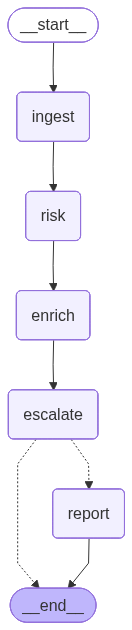

In [17]:
from IPython.display import Image, display


try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 7) Batch Execution & Case Collection

This block runs the entire workflow on a batch of transactions, collects escalated cases, and previews the results.

**How it works:**

1. **Initialization**  
   - Creates empty lists `cases` and `reports` to store outputs.  
   - Iterates through each transaction in the prepared batch (`tx_batch`).

2. **Run the Workflow**  
   - For each transaction:  
     - Converts the row into a `TxnEvent` object with `make_txn_event`.  
     - Wraps it in an initial `CaseState` with empty logs.  
     - Passes the state into the compiled LangGraph app (`app.invoke`).  
     - Retrieves the final updated case.

3. **Collect Escalated Cases**  
   - If the Escalation Agent decided to create a case:  
     - Appends key details into the `cases` list:  
       - Transaction ID  
       - Customer ID  
       - Amount  
       - Risk level and score  
       - Escalation severity  
       - Decision reason  
     - If a compliance report was generated, appends it to the `reports` list.

4. **Organize Results**  
   - Converts `cases` into a Pandas DataFrame (`cases_df`).  
   - Sorts by severity, risk score, and amount (descending order).  
   - Prints a summary: number of escalated cases vs. total processed.  
   - Displays the top 20 cases for quick review.

**Why this matters:**  
This step demonstrates the **end-to-end pipeline in action**:  
- Each transaction flows through ingestion, risk assessment, enrichment, escalation, and reporting.  
- Escalated cases are systematically collected and ranked by severity and risk.  
- Compliance teams can immediately see the highest-priority alerts.

In [18]:
import logging

# --- Clean up noisy loggers ---
logging.getLogger("httpx").setLevel(logging.WARNING)
logging.getLogger("openai").setLevel(logging.WARNING)
logging.getLogger("azure").setLevel(logging.WARNING)

# --- Workflow logger ---
logger = logging.getLogger("workflow")
logger.setLevel(logging.INFO)
if not logger.hasHandlers():
    ch = logging.StreamHandler()
    ch.setFormatter(logging.Formatter("%(asctime)s [%(levelname)s] %(message)s"))
    logger.addHandler(ch)

# --- Run transactions through workflow ---
cases, reports = [], []
total = len(tx_batch)

for i, (_, row) in enumerate(tx_batch.iterrows(), start=1):
    txn = make_txn_event(row)
    logger.info(f"Processing transaction {i}/{total} "
                f"(ID={txn.transaction_id}, Amount={txn.amount:.2f})")

    # Run workflow with thread_id to avoid checkpointer error
    state = {"case": CaseState(txn=txn, logs=[])}
    final = app.invoke(state, config={"configurable": {"thread_id": f"txn-{txn.transaction_id}"}})
    case = final["case"]

    # Collect results
    if case.decision and case.decision.create_case:
        logger.info(f"Escalated Txn {txn.transaction_id} | Severity={case.decision.severity}")
        cases.append({
            "transaction_id": case.txn.transaction_id,
            "customer_id": case.txn.customer_id,
            "amount": case.txn.amount,
            "risk_level": case.risk.risk_level if case.risk else None,
            "risk_score": case.risk.score if case.risk else None,
            "severity": case.decision.severity,
            "reason": case.decision.reason
        })
        if case.report:
            reports.append(case.report.model_dump())
    else:
        logger.info(f"Transaction {txn.transaction_id} not escalated")

# --- Build DataFrame of cases ---
if len(cases) == 0:
    logger.warning("No escalated cases found in this batch.")
    cases_df = pd.DataFrame()
else:
    cases_df = pd.DataFrame(cases).sort_values(
        ["severity", "risk_score", "amount"], ascending=[False, False, False]
    )
    rprint(f"[bold cyan]Escalated cases:[/bold cyan] {len(cases_df)} / {len(tx_batch)}")
    display(cases_df.head(20))


2025-10-08 10:48:37,169 [INFO] Processing transaction 1/200 (ID=85777, Amount=5570.42)
2025-10-08 10:48:48,721 [INFO] Escalated Txn 85777 | Severity=Medium
2025-10-08 10:48:48,722 [INFO] Processing transaction 2/200 (ID=26854, Amount=2308.05)
2025-10-08 10:48:51,098 [INFO] Transaction 26854 not escalated
2025-10-08 10:48:51,098 [INFO] Processing transaction 3/200 (ID=5027, Amount=9568.49)
2025-10-08 10:48:59,304 [INFO] Escalated Txn 5027 | Severity=Medium
2025-10-08 10:48:59,311 [INFO] Processing transaction 4/200 (ID=8024, Amount=1992.87)
2025-10-08 10:49:02,195 [INFO] Transaction 8024 not escalated
2025-10-08 10:49:02,195 [INFO] Processing transaction 5/200 (ID=66194, Amount=8557.44)
2025-10-08 10:49:08,212 [INFO] Escalated Txn 66194 | Severity=Medium
2025-10-08 10:49:08,212 [INFO] Processing transaction 6/200 (ID=61639, Amount=7388.97)
2025-10-08 10:49:15,179 [INFO] Escalated Txn 61639 | Severity=Medium
2025-10-08 10:49:15,179 [INFO] Processing transaction 7/200 (ID=71580, Amount=42

Escalated cases: 94 / 200

,transaction_id,customer_id,amount,risk_level,risk_score,severity,reason
83,50393,897,9852.14,Medium,0.5,Medium,High amount >= 5000
8,28624,82,9792.96,Medium,0.5,Medium,High amount >= 5000
41,44236,520,9602.28,Medium,0.5,Medium,High amount >= 5000
1,5027,6,9568.49,Medium,0.5,Medium,High amount >= 5000
24,23781,291,9535.77,Medium,0.5,Medium,High amount >= 5000
54,33611,605,9441.63,Medium,0.5,Medium,High amount >= 5000
50,30685,593,9353.18,Medium,0.5,Medium,High amount >= 5000
42,79628,525,9342.13,Medium,0.5,Medium,High amount >= 5000
63,32666,728,9252.80,Medium,0.5,Medium,High amount >= 5000
62,99554,723,9224.79,Medium,0.5,Medium,High amount >= 5000


### Report Previews

This block provides a quick look at the **first few compliance reports** generated by the Report Agent.

**How it works:**

1. **Iterate over reports**  
   - Loops through the first 5 reports in the `reports` list.  
   - Each report is enumerated and labeled (`Report 1`, `Report 2`, etc.).

2. **Display report content**  
   - **Title** → printed at the top of each report section.  
   - **Summary** → a concise narrative generated by the Report Agent.  
   - **Indicators** → prints up to 6 risk signals (e.g., high amount, PEP flag, high-risk jurisdiction).  
   - **Recommendation** → suggested compliance action (e.g., escalate, monitor, or dismiss).

3. **Output format**  
   - Clean, human-readable text blocks for each report.  
   - Highlights the most critical elements investigators care about:  
     - Why the case was flagged.  
     - What risk factors triggered it.  
     - What to do next.

**Why this matters:**  
Previewing reports shows how the pipeline transforms raw transaction data into **structured, audit-ready compliance documentation**.  
This mirrors a real-world workflow where machine-generated drafts support human investigators in making final decisions.


In [27]:
from IPython.display import Markdown, display

# Safeguard if reports is missing or empty
if 'reports' not in globals() or reports is None or len(reports) == 0:
    display(Markdown("> No reports to display."))
else:
    for i, rpt in enumerate(reports[:5], 1):
        title = rpt.get('title', 'Untitled')
        summary = rpt.get('summary', '')
        indicators = rpt.get('indicators', []) or []
        recommendation = rpt.get('recommendation', '')

        md = (
            f"### Report {i}: {title}\n\n"
            f"{summary}\n\n"
            f"**Indicators:**\n"
            + "\n".join([f"- {ind}" for ind in indicators[:6]])
            + ("\n\n**Recommendation:** " + recommendation if recommendation else "")
        )
        display(Markdown(md))


### Report 1: Medium Risk Transaction Review - Customer ID 1

A transaction involving a transfer of $5,570.42 by Customer ID 1 on March 28, 2018, has been flagged for review due to its amount exceeding the $5,000 threshold, classifying it as medium risk. No additional risk factors were identified.

**Indicators:**
- Transaction amount exceeds $5,000 threshold
- Medium risk level assigned due to transaction amount

**Recommendation:** Conduct a detailed review of Customer ID 1's transaction history and profile to determine if further investigation is warranted. Consider monitoring future transactions for any unusual patterns or activities.

### Report 1: Medium Risk Transaction Review - Customer ID 1

A transaction involving a transfer of $5,570.42 by Customer ID 1 on March 28, 2018, has been flagged for review due to its amount exceeding the $5,000 threshold, classifying it as medium risk. No additional risk factors were identified.

**Indicators:**
- Transaction amount exceeds $5,000 threshold
- Medium risk level assigned due to transaction amount

**Recommendation:** Conduct a detailed review of Customer ID 1's transaction history and profile to determine if further investigation is warranted. Consider monitoring future transactions for any unusual patterns or activities.

### Report 2: Medium Risk Transaction Review for Customer ID 6

A transaction involving Customer ID 6 on March 28, 2018, has been flagged for review due to its high amount, which exceeds the standard threshold for scrutiny. The transaction is classified as medium risk, primarily due to its value, with no additional risk factors identified.

**Indicators:**
- Transaction amount exceeds $5000 threshold
- Medium risk classification due to transaction value

**Recommendation:** Conduct a detailed review of Customer ID 6's transaction history and profile to ensure compliance with internal policies. Consider monitoring future transactions for any patterns or anomalies.

### Report 3: Medium Risk Transaction Review for Customer 15

A transaction involving Customer 15 on March 27, 2018, was flagged for review due to its high amount, exceeding the $5000 threshold, resulting in a medium risk level. No additional risk factors were identified.

**Indicators:**
- Transaction amount exceeds $5000 threshold
- Medium risk level assigned

**Recommendation:** Conduct a detailed review of Customer 15's transaction history and profile to ensure compliance with internal policies and regulatory requirements. Consider monitoring future transactions for any unusual patterns.

### Report 4: Medium Risk Transaction Review for Customer ID 19

A transaction involving Customer ID 19 on March 27, 2018, was flagged for review due to its high amount, exceeding $5000, which classifies it as medium risk. No additional risk factors were identified.

**Indicators:**
- Transaction amount exceeds $5000
- Medium risk level assigned

**Recommendation:** Conduct a detailed review of the customer's transaction history and profile to ensure compliance with internal risk management policies. Consider monitoring future transactions for any unusual patterns.

### Report 5: Medium Risk Transaction Review - Customer ID 39

A transaction involving Customer ID 39 on March 29, 2018, was flagged for review due to its high amount exceeding $5000, categorizing it as medium risk. No additional risk factors were identified.

**Indicators:**
- Transaction amount exceeds $5000
- Medium risk level assigned
- No keyword flags or recent transaction activity

**Recommendation:** Conduct a detailed review of Customer ID 39's transaction history and profile to determine if further action is necessary. Consider monitoring future transactions for any unusual patterns.


## 8) Quick Evaluation
- Alert Rate = escalated / processed
- Try disabling enrichment and compare


In [28]:
alert_rate = (len(cases)/len(tx_batch)) if len(tx_batch) else 0
print(f"Alert Rate: {alert_rate:.2%}")


Alert Rate: 47.00%



## 9) Conclusion
You implemented a collaborative multi-agent system with LangChain and LangGraph on Azure OpenAI, producing end-to-end monitoring with clear, auditable steps ready for extension into a production case-management flow.
